# Data Pre-Processing

#### Import Packages and CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv("/content/cardekho_dataset.csv")

# Print shape of dataset
print(df.shape)

(15411, 14)


## Data Cleaning

### Handling Missing values

* Handling Missing values
* Handling Duplicates
* Check data type
* Understand the dataset

#### Check Null Values

In [2]:
##Check features with nan value
df.isnull().sum()

,0
Unnamed: 0,0
car_name,0
brand,0
model,0
vehicle_age,0
km_driven,0
seller_type,0
fuel_type,0
transmission_type,0
mileage,0


### 3.2 Other Data Cleaning steps

**Handling Duplicates**

In [3]:
df.duplicated().sum()

0

# Feature Engineering

In [4]:
df.loc[df['brand']== 'Ferrari']

,Unnamed: 0,car_name,brand,model,vehicle_age,km_driven,seller_type,fuel_type,transmission_type,mileage,engine,max_power,seats,selling_price
3799,4845,Ferrari GTC4Lusso,Ferrari,GTC4Lusso,2,3800,Dealer,Petrol,Automatic,4.0,3855,601.0,4,39500000


#### Brand and model column can be dropped as the information is already available in car_name

In [5]:
df.drop(['brand','model', 'Unnamed: 0'], axis=1, inplace=True)

### Type of Features

**Numeric Features**

In [6]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 7


**Categorical Features**

In [7]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 4


**Discrete Features**

In [8]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 2


**Continues Features**

In [9]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 5


### Multicollinearity Check
#### Correllation Heatmap

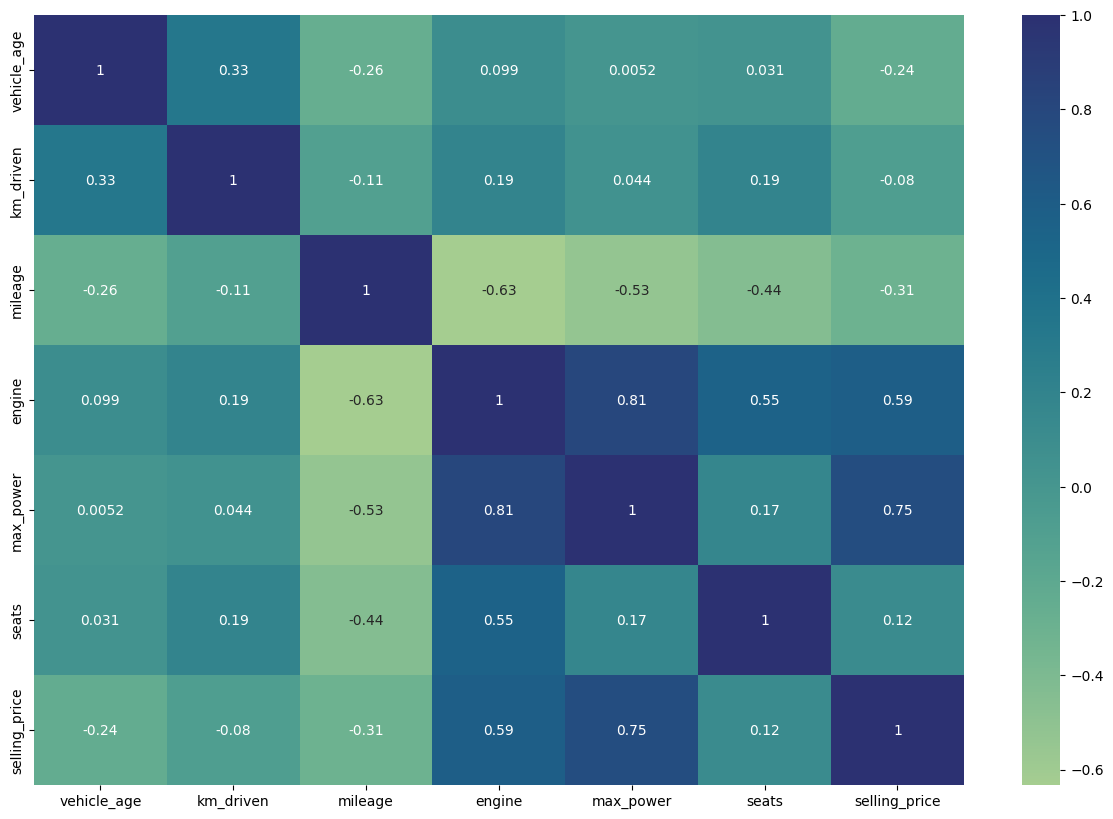

In [10]:
df_corr = df.drop(columns = ['car_name','seller_type','fuel_type','transmission_type'], axis=1).corr()

plt.figure(figsize = (15,10))
sns.heatmap(df_corr, cmap="crest", annot=True)  # CMRmap_r
plt.show()

**Report**
* Max power and Engine cc are highly correlated.
* We can check Vif to remove any highly correlated independent features.

#### Variance Inflation Factor (VIF)

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [11]:
import statsmodels.api as sm
num_features = df.select_dtypes(exclude="object").columns
for i in range(0, len(num_features)-1):
    x = df.loc[:, df.columns == num_features[i]]
    y = df.selling_price
    model = sm.OLS(x,y)
    results = model.fit()
    rsq = results.rsquared
    vif = round(1 / (1 - rsq), 2)
    print(
        "Variance Inflation Factor of {} column is {} \n".format(
            num_features[i], vif)
        )

Variance Inflation Factor of vehicle_age column is 1.34 

Variance Inflation Factor of km_driven column is 1.24 

Variance Inflation Factor of mileage column is 1.54 

Variance Inflation Factor of engine column is 2.41 

Variance Inflation Factor of max_power column is 3.13 

Variance Inflation Factor of seats column is 1.77 



**- This Dataset have MultiCollinearity in max_power column but not so much**

- Max Power and Engine are correlated but we can consider these two features because they hold important information for a vechicle.

### Check Outlier and Capping it

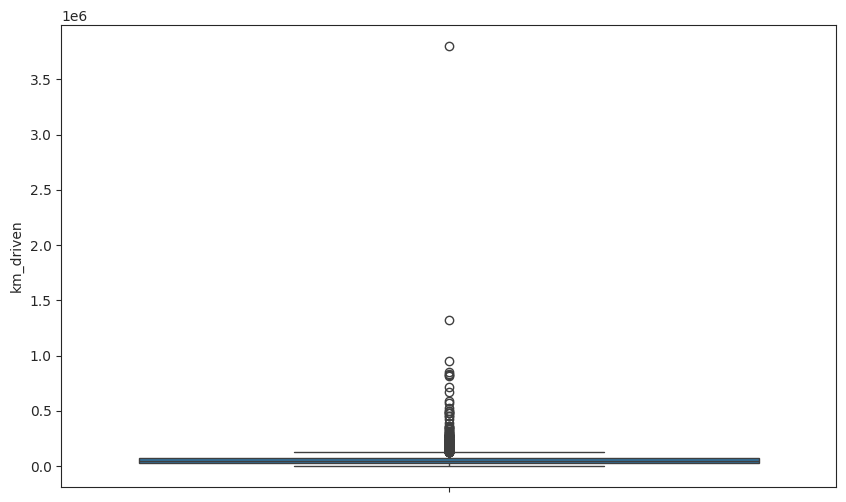

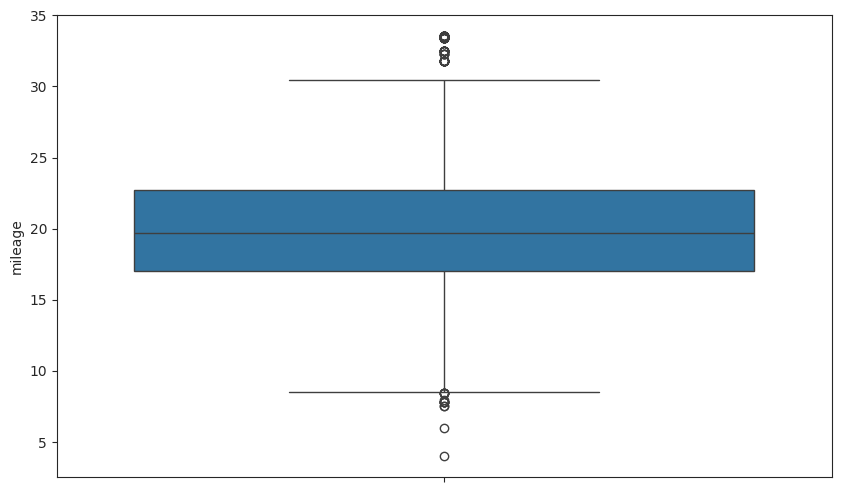

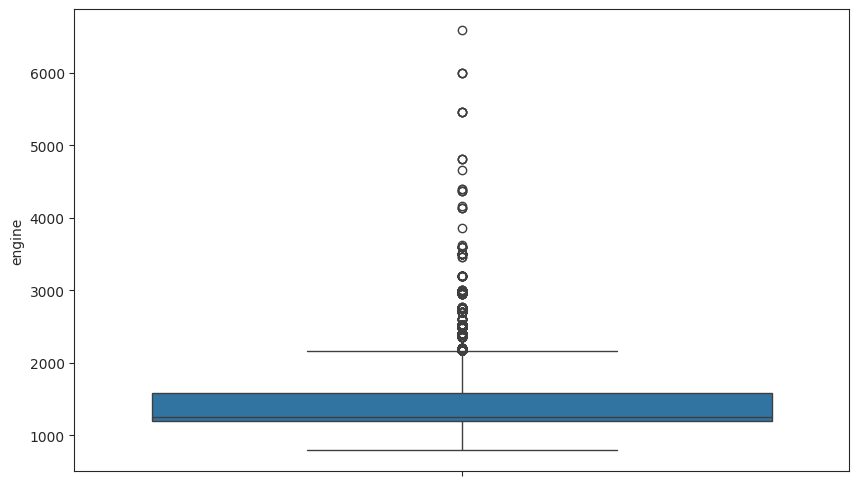

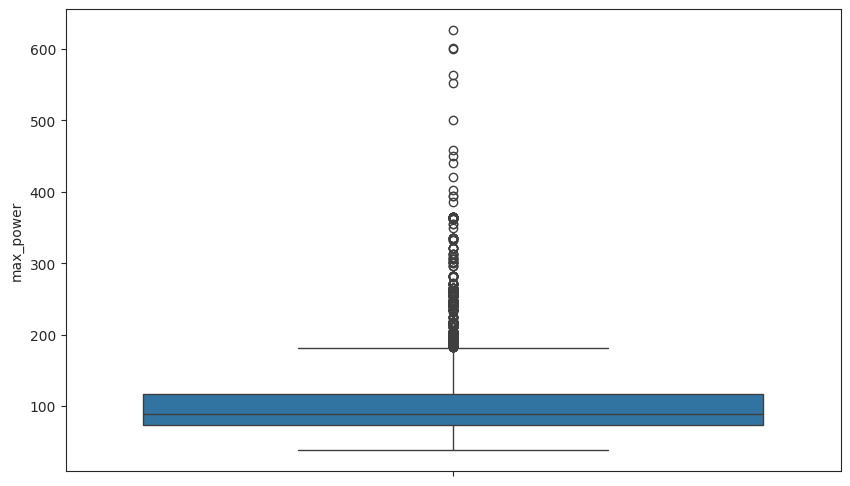

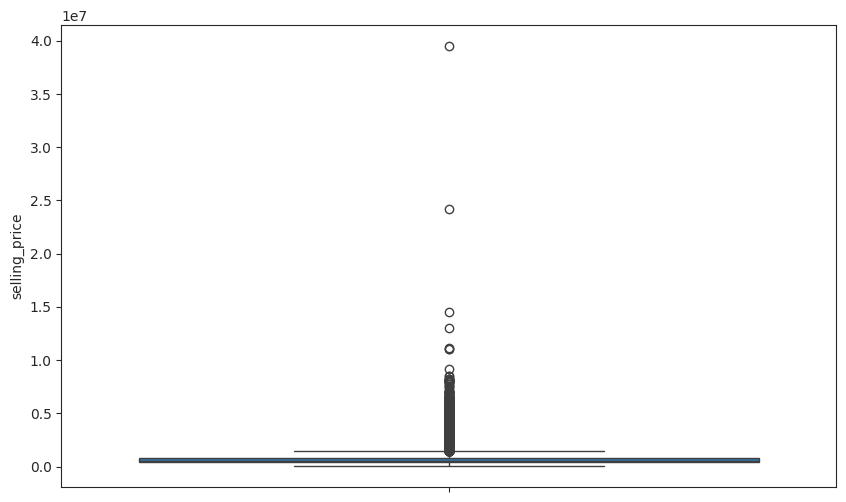

In [12]:
for i in continuous_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

**Detecting Outlier and Capping it**

In [13]:
def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit
    return df

**Why are we capping it and why not trim it ?**
* Trimming outliers may result in the removal of a large number of records from this dataset as we have already very less rows so this isn’t desirable in this case since columns other than the ones containing the outlier values may contain useful information.

* In this cases, you can use outlier capping to replace the outlier values with a maximum or minimum capped values. Be warned, this manipulates our data but we can replace outlier values by the upper and lower limit calculated using the IQR range.

In [14]:
for col in continuous_features:
         detect_outliers(col)


 #### km_driven ####
percentile25 30000.0
percentile75 70000.0
Upper limit 130000.0
Lower limit -30000.0

 #### mileage ####
percentile25 17.0
percentile75 22.7
Upper limit 31.25
Lower limit 8.450000000000001

 #### engine ####
percentile25 1197.0
percentile75 1582.0
Upper limit 2159.5
Lower limit 619.5

 #### max_power ####
percentile25 74.0
percentile75 117.3
Upper limit 182.25
Lower limit 9.050000000000011

 #### selling_price ####
percentile25 385000.0
percentile75 825000.0
Upper limit 1485000.0
Lower limit -275000.0


**Checking Skewness after Outlier Capping**

In [15]:
df[continuous_features].skew(axis=0, skipna=True)

,0
km_driven,0.617437
mileage,0.067940
engine,0.684096
max_power,1.067229
selling_price,0.968836


## Feature Transformation

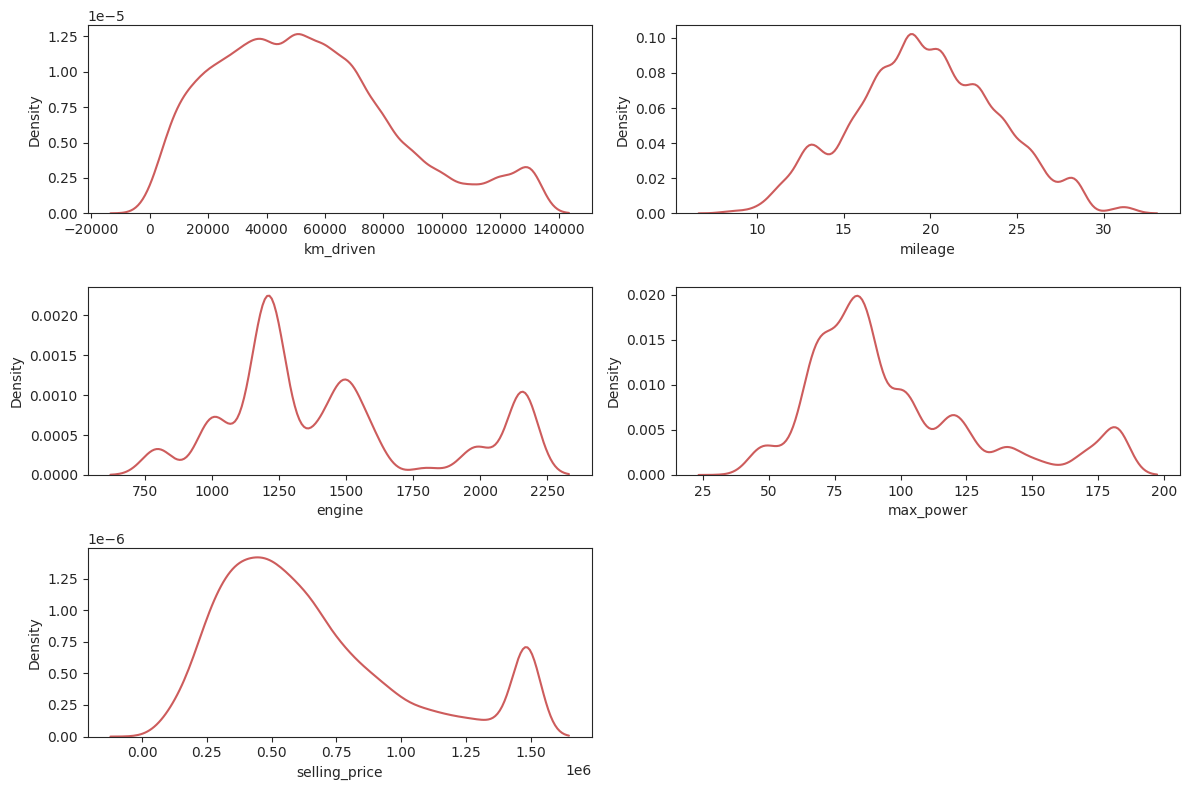

In [16]:
# distribution of data before scaling
plt.figure(figsize=(12, 8))
for i, col in enumerate(['km_driven', 'mileage', 'engine', 'max_power', 'selling_price']):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(x=df[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

**Report**
* After Capping Outlier it is all column's distribution is Normal so transformation is not required.

### Split X and Y

In [17]:
from sklearn.model_selection import train_test_split
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']

* **Split Dataframe to X and y**
* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “selling price” column.**


### Feature Selection

In [18]:
for feature in cat_features:
    print(feature,':', X[feature].nunique())

car_name : 121
seller_type : 3
fuel_type : 5
transmission_type : 2


## Feature Encoding and Scaling

**One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Binary Encoder**
* To fight the curse of dimensionality, binary encoding might be a good alternative to one-hot encoding because it creates fewer columns when encoding categorical variables.

In [20]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.2 MB/s eta 0:00:00


In [21]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
onehot_columns = ['seller_type','fuel_type','transmission_type']
binary_columns = ['car_name']

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.binary import BinaryEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
binary_transformer = BinaryEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, onehot_columns),
         ("StandardScaler", numeric_transformer, num_features),
        ("BinaryEncoder", binary_transformer, binary_columns)

    ]
)

In [22]:
X= preprocessor.fit_transform(X)

## Train Test Split

* The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

* It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [23]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((12328, 23), (3083, 23))

## Model Selection
* **Here should understand the Various Regression models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

**Import Required packages for model training**

In [25]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.5 MB/s eta 0:00:00


In [26]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

#### Create a Function to Evaluate Model

In [27]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [28]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 148770.0524
- Mean Absolute Error: 112850.1859
- R2 Score: 0.8380
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 155493.1551
- Mean Absolute Error: 118454.5725
- R2 Score: 0.8343


Lasso
Model performance for Training set
- Root Mean Squared Error: 148767.4172
- Mean Absolute Error: 112822.8031
- R2 Score: 0.8380
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 155479.5196
- Mean Absolute Error: 118418.6806
- R2 Score: 0.8343


Ridge
Model performance for Training set
- Root Mean Squared Error: 148770.8205
- Mean Absolute Error: 112835.0850
- R2 Score: 0.8380
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 155485.9482
- Mean Absolute Error: 118436.6096
- R2 Score: 0.8343


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 81895.5371
- Mean A

**Results of All Models**

In [29]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.943329
6,XGBRegressor,0.940491
5,Random Forest Regressor,0.932368
3,K-Neighbors Regressor,0.927522
4,Decision Tree,0.894437
1,Lasso,0.834332
2,Ridge,0.834318
0,Linear Regression,0.834303
8,AdaBoost Regressor,0.787452


**Here we can use Random Forest , XGBoost Regressor, CatBoost Regressor and K-Neighbours Regressor for Hyper Parameter Tuning**

In [30]:
#Initialize few parameter for Hyperparamter tuning
knn_params = {"n_neighbors": [2, 3, 10, 20, 40, 50]}

rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

cat_params = {"learning_rate": [0.1, 0.01, 0.06, 0.05],
              "max_depth": [6, 8, 12, 20, 30]}

In [31]:
# Models list for Hyperparameter tuning
randomcv_models = [('KNN', KNeighborsRegressor(), knn_params),
                   ("RF", RandomForestRegressor(), rf_params),
                   ('XGBoost', XGBRegressor(), xgboost_params),
                   ('CatBoost', CatBoostRegressor(verbose=False), cat_params)
                   ]

In [32]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
---------------- Best Params for KNN -------------------
{'n_neighbors': 10}
---------------- Best Params for RF -------------------
{'n_estimators': 1000, 'min_samples_split': 8, 'max_features': 8, 'max_depth': None}
---------------- Best Params for XGBoost -------------------
{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
---------------- Best Params for CatBoost -------------------
{'max_depth': 8, 'learning_rate': 0.05}


### Retraining the Model with best Parameters

In [33]:
models = {
    "Random Forest Regressor": RandomForestRegressor(**model_param['RF'], n_jobs=-1),
     "K-Neighbors Regressor": KNeighborsRegressor(**model_param['KNN'], n_jobs=-1),
    "XGBRegressor": XGBRegressor(**model_param['XGBoost'], n_jobs=-1),
     "CatBoosting Regressor": CatBoostRegressor(**model_param['CatBoost'],verbose=False)
}

model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')

Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 63625.9968
- Mean Absolute Error: 44660.7363
- R2 Score: 0.9704
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 93415.2123
- Mean Absolute Error: 63803.1244
- R2 Score: 0.9402


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 90424.3097
- Mean Absolute Error: 61141.1502
- R2 Score: 0.9401
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 103753.0193
- Mean Absolute Error: 69759.3010
- R2 Score: 0.9262


XGBRegressor
Model performance for Training set
- Root Mean Squared Error: 77451.0017
- Mean Absolute Error: 56011.4443
- R2 Score: 0.9561
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 92845.3741
- Mean Absolute Error: 63949.8738
- R2 Score: 0.9409


CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 6

In [34]:
pd.DataFrame(list(zip(model_list, r2_list*100)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
3,CatBoosting Regressor,0.943743
2,XGBRegressor,0.940924
0,Random Forest Regressor,0.940196
1,K-Neighbors Regressor,0.926228


### Best Model is CATBoost Regressor with 94.37% R2 Score